# Pair Statistics
This file attempts to gather correlations and ratios between many combinations of pairs of stocks. This is the first part in a two-part process of obtaining and processing data.

After the correlated stocks are calculated (for a given offset), we choose the most correlated pair and gather sentiment analysis data (part two) on each of the chosen stocks.

1. Gather Data
2. Find Correlation

In [2]:
# !pip install --user jugaad_data yfinance

  Using cached jugaad_data-0.23-py3-none-any.whl (26 kB)
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [1]:
!pip install --user yfinance

In [2]:
from datetime import date
# from jugaad_data import nse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
import csv
import yfinance
import seaborn as sbn

## 1. Gather Data

#### Get stock tickers

In [4]:
# Futures
# '''
# # Gather all symbols from CSV
# with open('fo_mktlots.csv') as fp:
#     reader = csv.reader(fp)
#     rows = list(reader)
#     # stocks start from 5th row and symbols are in 2nd column
#     fno_stocks = [row[1].lstrip().rstrip() for row in rows[5:]]
    
# print("Stocks in F&O: {}".format(len(fno_stocks)))
# '''

In [21]:
# Stocks from NYSE

# Gather all symbols from CSV
stocks = pd.DataFrame(columns=['Ticker', 'Close', 'Market Cap'])
with open('stock_symbols.csv') as f:
    reader = csv.reader(f)
    rows = list(reader)
    
    for i, row in enumerate(tqdm(rows)):
        if i == 0 or row[2] == 'n/a':
            continue
        try:
            row = pd.Series([row[0].lstrip().rstrip(), float(row[2]), row[3]], index=stocks.columns)
            stocks = stocks.append(row, ignore_index=True)
        except:
            print('Error with ticker:', row[0])
    
print("Stocks in our NYSE: {}".format(len(stocks)))

  0%|          | 0/6552 [00:00<?, ?it/s]

Stocks in our NYSE: 6515


In [22]:
stocks.head()

,Ticker,Close,Market Cap
0,AAPL,565.25,"$527,022,142,500"
1,XOM,84.57,"$397,687,211,340"
2,MSFT,30.98,"$259,946,085,580"
3,BAC^I,24.79,"$248,692,932,940"
4,IBM,204.99,"$236,452,685,160"


In [23]:
# Get Market Cap as a float instead of a currency string
stocks['Market Cap'] = stocks['Market Cap'].replace('\$|,', '', regex=True).astype(float)

# Clean ticker symbols
stocks['Ticker'] = stocks['Ticker'].replace('\^I|\^L|\^|\/.+', '', regex=True)

#### Filter stocks to only show certain (at least somewhat reliable companies)

In [24]:
# Change these at will
MIN_MARKET_CAP = 1000000
MIN_CLOSE = 50
MIN_VOLUME = 100000

In [25]:
stocks = stocks[(stocks['Market Cap'] > MIN_MARKET_CAP) & (stocks['Close'] > MIN_CLOSE)]
stocks = stocks.reset_index(drop=True)

In [26]:
print("Down to {} stocks in our NYSE".format(len(stocks)))

Down to 658 stocks in our NYSE


#### Download stock data for each ticker

In [143]:
# The delisted warnings are sadly something you will just have to deal with
# yfinance history is multithreaded, so the exceptions are in different threads. I could change threads=False, but then it is much slower.
def get_stock_data(stocks, from_date=date(2021,1,1), to_date=date(2021,7,10)):
    dfs = []

    for ticker in tqdm(stocks['Ticker']):
#         try:
        ticker = ticker.replace("/", "-").replace("^", "-")
        df = yfinance.Ticker(ticker)
#         info = df.info
        
#         if info['marketCap'] == None or info['marketCap'] == 0 or info['regularMarketVolume'] < MIN_VOLUME:
#             print(info)
#             continue
            
        df = df.history(start=from_date, end=to_date)
        if df is None or len(df) == 0:
             continue
        dfs.append((ticker, df))
#         except:
#             print("*** Issue retrieving stock data for {}".format(ticker))

    return dfs

In [245]:
dfs = get_stock_data(stocks, from_date=date(1990,1,1), to_date=date(2021,10,1))

  0%|          | 0/658 [00:00<?, ?it/s]

- UTX: No data found, symbol may be delisted
- PCLN: No data found for this date range, symbol may be delisted
- APC: No data found, symbol may be delisted
- PX: Data doesn't exist for startDate = 631152000, endDate = 1633046400
- CELG: No data found, symbol may be delisted
- AGN: No data found, symbol may be delisted
- TYC: No data found for this date range, symbol may be delisted
- TWC: No data found for this date range, symbol may be delisted
- WLP: No data found for this date range, symbol may be delisted
- COH: No data found for this date range, symbol may be delisted
- KMP: No data found for this date range, symbol may be delisted
- SHPGY: No data found for this date range, symbol may be delisted
- RTN: No data found, symbol may be delisted
- LO: No data found for this date range, symbol may be delisted
- MJN: No data found for this date range, symbol may be delisted
- WPPGY: No data found for this date range, symbol may be delisted
- NBL: No data found, symbol may be delisted
- 

In [252]:
print("Num companies =", len(dfs))
print("(Dates, features) =",dfs[0][1].shape)
print("Company:", dfs[0][0])
dfs[0][1].head()

Num companies = 487
(Dates, features) = (7994, 7)
Company: AAPL


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1990-01-02,1.247066,1.255435,1.171740,1.247066,45799600,0.0,0.0
1990-01-03,1.255435,1.272174,1.255435,1.255435,51998800,0.0,0.0
1990-01-04,1.259626,1.297283,1.247066,1.259626,55378400,0.0,0.0
1990-01-05,1.263805,1.280544,1.238696,1.263805,30828000,0.0,0.0
1990-01-08,1.272174,1.272174,1.238696,1.272174,25393200,0.0,0.0


Again, filter down our data. This time, we only want to look at stocks that have a "decent" volume.

In [253]:
MIN_AVG_VOLUME = 100000
def valid_stock(stock_data):
    return True if stock_data["Volume"].mean() > MIN_AVG_VOLUME else False

In [254]:
stocks['Ticker']

0      AAPL
1       XOM
2       IBM
3       CVX
4       WMT
       ... 
653    GNMA
654     FMS
655     LNC
656     BMY
657     GMT
Name: Ticker, Length: 658, dtype: object

In [255]:
# Combine data into one giant dataframe
all_stock_df = pd.DataFrame()
for i, (ticker, df) in enumerate(dfs):
    
    # Since we couldn't get data for many companies, fill in those removed rows by updating line numbers
    if valid_stock(df):
        all_stock_df[ticker] = df['Close']
    
print(all_stock_df.shape)
print(all_stock_df.head())

(7994, 402)
                AAPL       XOM        IBM       CVX       WMT       JNJ  \
Date                                                                      
1990-01-02  1.247066  4.275313  11.679734  5.267715  3.719669  3.580161   
1990-01-03  1.255435  4.232561  11.784039  5.181983  3.719669  3.595133   
1990-01-04  1.259626  4.189808  11.918095  5.115304  3.699907  3.602595   
1990-01-05  1.263805  4.168434  11.888297  5.039100  3.660438  3.565238   
1990-01-08  1.272174  4.232561  11.962811  5.086728  3.709753  3.625029   

                  PG        KO  GOOG  PM  ...  BIB  PED  PEB       PBI  VGSH  \
Date                                      ...                                  
1990-01-02  4.030787  2.336064   NaN NaN  ...  NaN  NaN  NaN  3.251693   NaN   
1990-01-03  4.023651  2.302378   NaN NaN  ...  NaN  NaN  NaN  3.251693   NaN   
1990-01-04  3.945023  2.291140   NaN NaN  ...  NaN  NaN  NaN  3.251693   NaN   
1990-01-05  3.873579  2.272429   NaN NaN  ...  NaN  NaN  NaN  

In [256]:
all_stock_df['AAPL']

Date
1990-01-02      1.247066
1990-01-03      1.255435
1990-01-04      1.259626
1990-01-05      1.263805
1990-01-08      1.272174
                 ...    
2021-09-24    146.705887
2021-09-27    145.158142
2021-09-28    141.703186
2021-09-29    142.621857
2021-09-30    141.293793
Name: AAPL, Length: 7994, dtype: float64

In [257]:
# Save our list of stock data
all_stock_df.to_csv("nyse_raw_data.csv", index=True)

In [3]:
all_stock_df = pd.read_csv("nyse_raw_data.csv")

## Find Correlation

Here is where we get a little bit creative. We want to run a correlation (corr()) on the pandas dataframe, but we want to check this out for select stocks with some sort of offset relative to all other stocks. 

What this means is that we want to find some stock that is highly or negatively correlated with another stock, but these correlations happen at a later point in time (allowing our program to give enough of a warning/heads up to buy/sell a stock).

In [258]:
offset_data = data.copy()
offset_data[ticker] = offset_data[ticker].shift(periods=offset)

# Ticker's column should move up by offset. The best way to think of this is that if today is day t, we want to find a correlation with prices from other stocks at time t-offset
stock_corr = offset_data.corr()

In [259]:
# print(stock_corr.head())
print("Original\n", all_stock_df.corr().head()['AAPL'])
print("Offset\n", stock_corr.head()['AAPL'])

print("\nDiff\n", stock_corr.head()['AAPL'] - all_stock_df.corr().head()['AAPL'])

Original
 AAPL    1.000000
XOM     0.762116
IBM     0.766655
CVX     0.897555
WMT     0.825682
Name: AAPL, dtype: float64
Offset
 AAPL    1.000000
XOM     0.761047
IBM     0.766209
CVX     0.896933
WMT     0.825727
Name: AAPL, dtype: float64

Diff
 AAPL    0.000000
XOM    -0.001068
IBM    -0.000446
CVX    -0.000622
WMT     0.000046
Name: AAPL, dtype: float64


Clearly with large amounts of data, minute shifts/offsets will not cause a big change in correlation. Howerver, we want our correlations to factor in the day by day changes. Hence, we need to write our own correlation function

In [471]:
def get_corr(ticker, data, offset=3, window_size=7):
    '''
    Input:
        ticker - Str
        data - N x N matrix
        with_offset - int number of days to shift
        window_size - how many days grouped together for each correlation calculation
        
    Output:
        offset_data - N x N (with offset # rows NaN)
        offset_corr - 1 x (N-offset)
    
    Takes price data from various companies at different days and offsets it by 'offset' # of rows/days.
    It then runs a corr on that data, returning how correlated ticker is with all other tickers given an offset
    
    Returns the offset data matrix, offset correlation matrix
    '''
    
    assert(ticker in data and len(data[ticker]) > 0)
    offset_data = data.copy()
    
    # Ticker's column should move up by offset. The best way to think of this is that if today is day t, we want to find a correlation with prices from other stocks at time t-offset
    offset_data[ticker] = offset_data[ticker].shift(periods=offset)
    
    offset_corrs = pd.DataFrame(columns=data.columns)
    for i in range(data.shape[0] - window_size):
        curr = offset_data.iloc[i:i+window_size]
        offset_corrs.loc[i] = curr.corr()[ticker]
        
    # Get the mean weekly correlation for each column (ignore NaN's = true by default)
    return offset_data, offset_corrs.mean(axis=0)

#### Now do it again for every stock at different offsets

In [167]:
# max_lag = 10
# lagged_correlation = pd.DataFrame.from_dict(
#     {x: [all_stock_df['BMO'].corr(all_stock_df[x].shift(-t)) for t in range(max_lag)] for x in all_stock_df.columns}
# )

In [168]:
# lagged_correlation

,AAPL,XOM,IBM,CVX,WMT,JNJ,PG,KO,GOOG,PM,...,PEB,PBI,VGSH,VGLT,VONG,VGIT,VTWO,VONV,LNC,BMY
0,-0.063153,0.891339,0.936141,0.822509,-0.090444,0.619970,0.541191,0.930849,0.907249,0.960726,...,0.557635,0.036532,-0.123869,-0.533141,0.657700,-0.568953,0.617136,0.955027,0.898562,0.717602
1,-0.054730,0.885233,0.931998,0.809663,-0.074247,0.606487,0.555442,0.932963,0.905144,0.956690,...,0.537890,0.008744,-0.119888,-0.507209,0.656598,-0.552496,0.602434,0.946726,0.883468,0.719018
2,-0.033214,0.878256,0.928754,0.795510,-0.055766,0.596527,0.575664,0.933520,0.904835,0.952866,...,0.519305,-0.011602,-0.111348,-0.474353,0.661737,-0.528453,0.587671,0.938574,0.866717,0.724756
3,-0.019922,0.871242,0.929998,0.782397,-0.031313,0.592080,0.605888,0.932792,0.905019,0.949893,...,0.503710,-0.026666,-0.107698,-0.444224,0.666348,-0.502933,0.576432,0.932678,0.852447,0.730587
4,0.000663,0.864255,0.930987,0.770122,-0.009750,0.590670,0.630123,0.930317,0.904609,0.949031,...,0.488833,-0.035114,-0.115481,-0.416329,0.672844,-0.480516,0.565443,0.926892,0.839333,0.735989
5,0.021228,0.857182,0.930603,0.757525,0.012192,0.585708,0.651043,0.930213,0.903485,0.948170,...,0.476210,-0.051187,-0.124605,-0.389277,0.679227,-0.460034,0.551231,0.920254,0.825540,0.740268
6,0.034666,0.850437,0.930091,0.744101,0.038356,0.580200,0.668990,0.927290,0.904482,0.946586,...,0.457358,-0.067829,-0.135316,-0.363929,0.683479,-0.442669,0.534126,0.912204,0.810649,0.753098
7,0.047872,0.842614,0.929199,0.730153,0.069776,0.573739,0.686878,0.925011,0.905486,0.944880,...,0.436867,-0.073317,-0.152934,-0.338242,0.688793,-0.426288,0.520934,0.904279,0.795268,0.771076
8,0.069000,0.830828,0.925880,0.711693,0.095247,0.566041,0.705864,0.922146,0.905709,0.943098,...,0.419657,-0.086025,-0.164664,-0.307891,0.697585,-0.407064,0.508460,0.895911,0.777772,0.781808
9,0.089518,0.820210,0.922827,0.694609,0.123021,0.558101,0.716682,0.917238,0.908820,0.941197,...,0.404812,-0.088812,-0.185717,-0.278607,0.708175,-0.387974,0.504359,0.888597,0.762131,0.799228


In [473]:
# Warning: Gathering weekly correlations on every single stock in our data set is quite costly, this will take (30s/stock * 402stocks * 1 min/60s * 1hr/60m* 3 different offsets =) 10.05 hours to run
# I will let this go over night. The goal here is to really do a deep, heavy analysis on many combinations of pairs in the stock market to see if there is any correlation
# This may seem slow, but I am super grateful that computers can churn through this data. I, on the other hand, can go and get some rest. See you in the morning!

threshold = 0.1
offsets = [1, 3, 7]
offsets = [7]
row_names = ['Ticker 1', 'Ticker 2', 'Corr']
row_names = [str(i+1)+"-"+name for i in range(10) for name in row_names]
max_pair = pd.DataFrame(np.zeros(( len(row_names), len(offsets))), row_names, offsets)

# Inserts a pair into the sorted max_pair
def insert(t1, t2, val, offset=7):
    assert(val > max_pair[offset]['10-Corr'])
    found = False
    last_pair, curr_pair = None, None
    for i, v in enumerate(max_pair[offset]):
        if i%3 != 2:
            continue
        if not found and (type(v) == float and val < v):
            continue
        elif type(v) == float or type(v) == np.float64:
            found = True
            curr_pair = [max_pair[offset][str((i // 3)+1)+"-Ticker 1"],
                        max_pair[offset][str((i // 3)+1)+"-Ticker 2"],
                        max_pair[offset][str((i // 3)+1)+"-Corr"]]
            
            # First time insert t1, t2, val
            if not last_pair:
                max_pair[offset][str((i // 3)+1)+"-Ticker 1"] = t1
                max_pair[offset][str((i // 3)+1)+"-Ticker 2"] = t2
                max_pair[offset][str((i // 3)+1)+"-Corr"] = val
            else:
                max_pair[offset][str((i // 3)+1)+"-Ticker 1"] = last_pair[0]
                max_pair[offset][str((i // 3)+1)+"-Ticker 2"] = last_pair[1]
                max_pair[offset][str((i // 3)+1)+"-Corr"] = last_pair[2]
            
            last_pair = curr_pair

for offset in tqdm(offsets, position=0, desc="Offsets"):
    for stock in tqdm(all_stock_df, position=1, desc="Stocks at offset " + str(offset), total=all_stock_df.shape[1]):
        
        # Get the correlation for this offset
        _, stock_corr = get_corr(stock, all_stock_df, offset=offset)
        
        # Filter to only show very high (anti-)correlation
        k = stock_corr[abs(stock_corr) > threshold]
        
        try:
            # Remove correlation with itself w/o in-place drop
            k = k.drop(stock, axis=0)
        except:
            pass
            print("Error with {}. Data may be missing/not listed.".format(stock))
    
        # This stock only has a high correlation with itself
        if len(k) == 0:
            continue

        if k.any() and len(k) > 1:
#             print(k.to_frame().T)
#             print('------------------------------------')

            # Makes the top 10
            if k.max() > max_pair[offset]['10-Corr']:
#                 max_pair[offset] = [stock, k.idxmax(), k.max()]
                insert(stock, k.idxmax(), k.max(), offset)
                print("New top-10 at offset {}: {} & {} --> {}, New min: {}, New max: {}".format(offset, stock, k.idxmax(), k.max(), max_pair[offset]['10-Corr'], max_pair[offset]['1-Corr']))
                
        
# New max at offset 5: RY & HBANP --> 0.158891285615675
# New max at offset 5: AMGN & ATHN --> 0.18920894382798814
# New max at offset 5: MA & CYT --> 0.21530355134336604
# New max at offset 5: NKE & CYT --> 0.2298681444224861
# New max at offset 5: YUM & CYT --> 0.2416256431854256
# New max at offset 5: SYK & CYT --> 0.3598651556977396 # Problem with this one, although it has decent correlation, is that it is so new to the stock market (only 6 months) and is therefore an unfair estimate

# So, I went ahead and built my own max_pair structure to hold the top 10 pairs, then constructed a basic sorted insert function to make things easier to see.
# Hopefully, this will do the job of including the important correlations without being overthrown by small extraneous stocks


Offsets:   0%|          | 0/1 [00:00<?, ?it/s]

Stocks at offset 7:   0%|          | 0/402 [00:00<?, ?it/s]

New top-10 at offset 7: AAPL & VAL --> 0.1008077431729057
New top-10 at offset 7: GOOG & ACE --> 0.10038115257594184
New top-10 at offset 7: ABT & VAL --> 0.14408168648969066
New top-10 at offset 7: MCD & VAL --> 0.10554627563806918
New top-10 at offset 7: SLB & CYT --> 0.11857038754560924
New top-10 at offset 7: RY & HBANP --> 0.14606795991037572
New top-10 at offset 7: HD & ACE --> 0.1316342912782925
New top-10 at offset 7: CAT & HBANP --> 0.1253678632626025
New top-10 at offset 7: BA & ACE --> 0.1840354665153373
New top-10 at offset 7: UNP & ACE --> 0.14628726092261135
New top-10 at offset 7: GS & ATHN --> 0.14720310689947044
New top-10 at offset 7: EPD & ACE --> 0.16275197377252418
New top-10 at offset 7: BMO & HBANP --> 0.13526043811411645
New top-10 at offset 7: BIDU & ACE --> 0.177694950361466
New top-10 at offset 7: PNC & ATHN --> 0.2082540559199896
New top-10 at offset 7: DE & CYT --> 0.14184972713852517
New top-10 at offset 7: NOV & ATHN --> 0.1354723091526334
New top-10 at o

In [493]:
max_pair

,7
1-Ticker 1,CYT
1-Ticker 2,NGG
1-Corr,0.405429
2-Ticker 1,DLTR
2-Ticker 2,CYT
2-Corr,0.287651
3-Ticker 1,SUN
3-Ticker 2,CYT
3-Corr,0.285257
4-Ticker 1,COHR


In [133]:
# Generate a little heatmap of the most correlated stocks. It is almost meaningless since it's already sorted, but it's just for fun!
def show_heatmap(data):
    return sbn.heatmap(data)

## Visualizing the correlation
The computer is quick to compute a super-strong correlation. Does this mean that the stock moves together with our offset? Did I have messed up somewhere along the process? Or do I not understand Pearson Correlation efficients as well as I thought?

The best way to find out is to see the correlation for ourselves!

In [503]:
# Let's start by looking at our 7 day offset

# Regather the offset data
offset_data, stock_corr = get_corr(max_pair[7]['1-Ticker 1'], all_stock_df, offset=offset)

In [478]:
stock_corr[max_pair[7]['1-Ticker 2']]

0.4054294423564019

A correlation of 0.4 is pretty high for the stock market, but keep in mind that the data is fairly limited for CYT and thus is not the most fair estimate.We notice the same thing with VAL and HBANP. Unfortunately, at this point, we will try to train with one of these pairs, but in the future, one thing I would've liked to change knowing this is the minute-breakdowns of data so that the model would have more to train on.

With that said, VAL and HBANP have been around since for at least 6 months, so we will train off of that data

In [504]:
max_pair[7]['4-Ticker 1'], max_pair[7]['4-Ticker 2'], max_pair[7]['4-Corr']

('COHR', 'VAL', 0.2828746535900576)

In [498]:
offset_data, stock_corr = get_corr(max_pair[7]['4-Ticker 1'], all_stock_df, offset=offset)

CPA


Date
1990-01-17          NaN
1990-01-18          NaN
1990-01-19          NaN
1990-01-22          NaN
1990-01-23          NaN
                ...    
2021-09-24    78.279999
2021-09-27    79.320000
2021-09-28    78.690002
2021-09-29    79.019997
2021-09-30    79.180000
Name: CPA, Length: 7983, dtype: float64

In [505]:
print(max_pair[7]['4-Ticker 1'])
offset_data[max_pair[7]['4-Ticker 2']][-11:]

COHR


Date
2021-09-16    32.000000
2021-09-17    31.330000
2021-09-20    30.719999
2021-09-21    31.469999
2021-09-22    32.450001
2021-09-23    33.930000
2021-09-24    34.070000
2021-09-27    34.700001
2021-09-28    34.900002
2021-09-29    34.270000
2021-09-30    34.880001
Name: VAL, dtype: float64

In [ ]:
# stock_corr.style.background_gradient(cmap='coolwarm')

(18727.0, 18941.0)

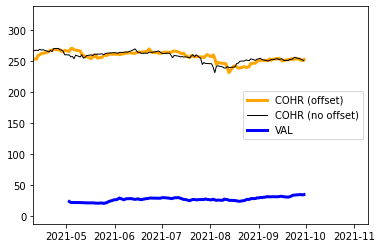

In [509]:
n = 4
plt.plot(offset_data[max_pair[7][str(n)+'-Ticker 1']], color='orange', linewidth=3.0)
plt.plot(all_stock_df[max_pair[7][str(n)+'-Ticker 1']], color='k', linewidth=1.0)
plt.plot(offset_data[max_pair[7][str(n)+'-Ticker 2']], color='b', linewidth=3.0)
plt.legend([max_pair[7][str(n)+'-Ticker 1'] + ' (offset)', max_pair[7][str(n)+'-Ticker 1'] + ' (no offset)', max_pair[7][str(n)+'-Ticker 2']])
plt.xlim(date(2021,4,10), date(2021,11,10))

## 3. Gather takeaways and export data for model

So... what do we know at this point? From our original broad pearson correlation data, we noticed that some of our highest offset correlations are all from banks. Hmph. This can be a bit aggravating, and I was considering removing all bank stocks from my dataset since banks tend to move together and with the rest of the market. However, truthfully this fact does not matter, if it happens to have a high offset correlation, perhaps it is the case that bank stocks have a repeated pattern.

For example, since this is a 7 day offset that we are looking at, we might hypothesize that bank stocks mirror the following pattern:
- Mondays: bank stocks go up.
- Tuesdays: bank stocks go up more.
- Wednesday: bank stocks go down.
- Thursday: bank stocks go down.
- Friday: bank stocks go up.

If this is the case, then perhaps it could explain why the Royal Bank of Canada (RY) and the Bank of Montreal (BMO) have such similar 7-day offset correlations... it would thus follow that RY also has high correlation with itself in a 7-day offset. In fact, let's prove this true or false because now I'm curious!

In [222]:
# copy = all_stock_df.copy()
# ry_data = copy['RY'].to_frame()
# ry_data["RY +7"] = ry_data['RY'].shift(periods=7)
# ry_corr = ry_data.corr()

In [223]:
# ry_corr

,RY,RY +7
RY,1.000000,0.962995
RY +7,0.962995,1.000000


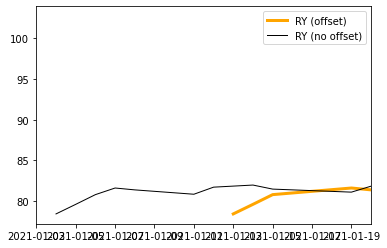

In [229]:
# plt.plot(ry_data['RY +7'], color='orange', linewidth=3.0)
# plt.plot(ry_data['RY'], color='k', linewidth=1.0)
# plt.xlim(date(2021,1,3), date(2021,1,20))#date(2021,4,10), date(2021,6,10))
# plt.legend(['RY (offset)', 'RY (no offset)'])

Interesting... so maybe there was a weekly pattern to bank stocks after all. In any event, if there's correlation, there's correlation! We would see if we can train a model to predict its current movement based on correlation and previous data. However, we fixed our correlations to make it look at the weekly changes. Thus, we go to the limited data we have.

#### (Removed) Let's explore the industry/sector of the highly correlated stocks

In [18]:
# for stock in all_stock_df:
#     t = yfinance.Ticker(stock)
#     print("Ticker:", stock, "Industry:", t.info["sector"])
#     break

Industry: Technology


#### Collect stats on our pairs to further investigate possible pairs

In [ ]:
# First, we need to have a dictionary/2d array which can list all possible pairs
# Then, we can calculate the ratios to all these stocks for each day
ratios = stock_1['CLOSE'] / stock_2['CLOSE']

Finally, with these statistics calculated, the last bit of information we want to add to our feature space will be social media sentiment. Will these correlated stocks have early warning indicators from social media? That's what we aim to find out!